Importing libraries

In [1]:
from numpy import *
from pandas import read_csv
from matplotlib.pyplot import *
n = 1.00866491588 #u
p = 1.007276466621 #u
uc2 = 931.49410242 # MeV

Reading and cleaning data

In [2]:
Data = read_csv("all_nuclei.csv")
toremove = []
for i in Data.index:
    if(Data["N"][i]> 3*Data["Z"][i]):
        toremove.append(i)
Data = Data.drop(toremove)
Data = Data.drop(Data.index[:300])
N = Data["N"]
Z = Data["Z"]
A = N+Z
M = Data["mass"] # in 'u'
BE = (N*n+Z*p-M)*uc2 # in MeV
Data["BE"] = BE
Data["A"] = A
Data["BE/A"] = BE/A

A function to plot the N-Z plot

In [3]:
def Plot(aC,aA):
    global Data
    Data.plot.scatter("Z","N",color ="BE/A",s=0.3,colormap='viridis')
    A = linspace(1,300,100)
    Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))
    N = A-Z
    plot(Z,N,'black')
    show()

Rewriting data in correct format

In [4]:
Del0 = 1 #MeV
aPt  = A**(-1/2)
for i in Data.index:
    if A[i]%2 == 0:
        aPt[i] = 0
    elif Z[i]%2==1:
        aPt[i] = -aPt[i]
aVt = A
aSt = -A**(2/3)
aCt = -Z*(Z-1)*A**(-1/3)
aAt = -((N-Z)**2)/A

# Linear Regression

In [5]:
def LinearRegression(X,y):
    XTX = X.T @ X
    pseudoinverse = linalg.inv(XTX) @ X.T
    return dot(pseudoinverse,y)

With contribution from pairing term

[1.55875070e+01 1.82662257e+01 7.20055938e-01 2.24786143e+01
 1.39098450e-02]


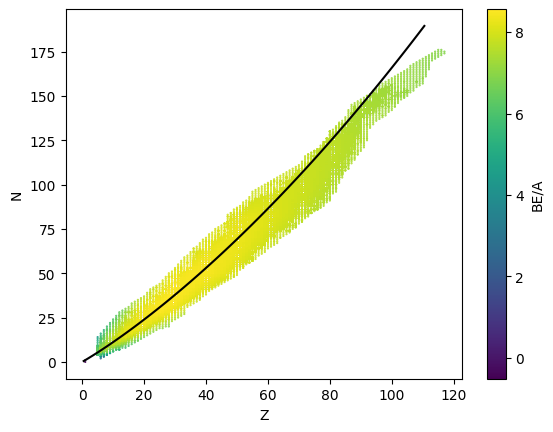

In [6]:
theta = LinearRegression(array([aVt,aSt,aCt,aAt,aPt]).T,array(BE))
print(theta)
aV,aS,aC,aA,aP = theta
Plot(aC,aA)

Ignoring the pairing term

[15.58753449 18.26631066  0.72005804 22.47863681]


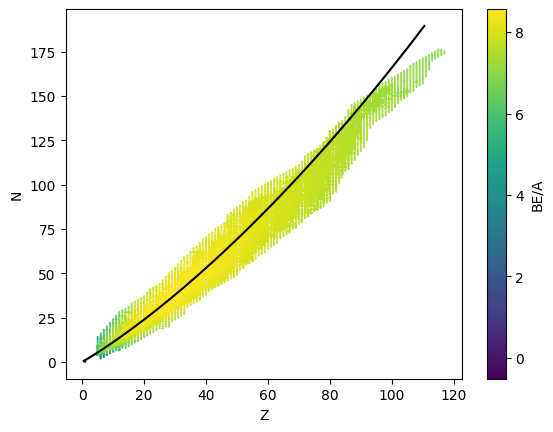

In [7]:
theta = LinearRegression(array([aVt,aSt,aCt,aAt]).T,array(BE))
print(theta)
aV,aS,aC,aA = theta
Plot(aC,aA)

Optimising for just the N-Z curve, not the full bond energy related data :

0.7200580445502925 25.9858707688972


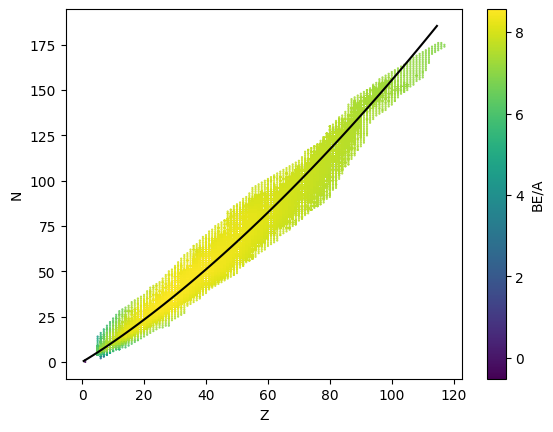

In [8]:
X = array([4*(A-2*Z)]).T
y = array(aC*(2*Z-1)*A**(2/3))
aA, = LinearRegression(X,y)
print(aC,aA)
Plot(aC,aA)

# Gradient descent for linear models

In [9]:
class LinearBatch:
    def __init__(self,X,y):
        self.y = y
        self.X = X
        self.y2 = dot(y,y)
        self.XTy = dot(X.T,y) 
        self.XTX = X.T @ X
        self.N = y.shape[0]

    def L(self,theta):
        MSE = self.y2
        MSE += -2*dot(self.XTy,theta)
        MSE += dot(theta,dot(self.XTX,theta))
        return MSE

    def grad(self,theta):
        toret = dot(self.XTX,theta)
        toret -= self.XTy
        toret = 2*toret
        return toret
    
    def descend(self,theta,stopingvalue):
        g = self.grad(theta)
        g2 = dot(g,g)
        L0 = self.L(theta)
        print("starting",L0,theta)
        h = 1
        while h*g2 > stopingvalue:
            g2 = dot(g,g)
            while L0 - self.L(theta-g*h) > g2*h/2:
                h = h*2
            while L0 - self.L(theta-g*h) < g2*h/2:
                h = h/2
            theta = theta - g*h
            g = self.grad(theta)
            L0 = self.L(theta)
        print("after descend",L0,theta)
        return theta


Applying on our data

starting 262562196070.9098 [20 15  0 20]


after descend 1289051.529083252 [15.38362465 17.62914781  0.70614659 21.97023551]


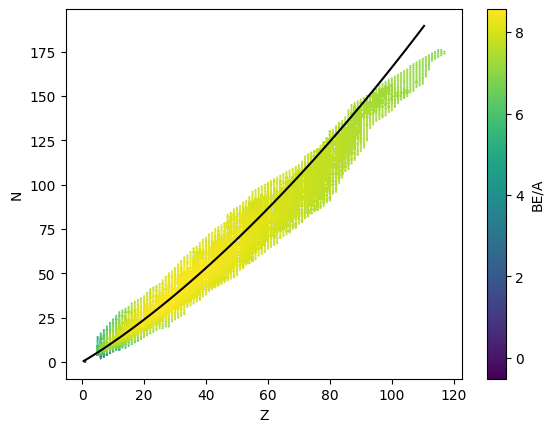

In [10]:

B = LinearBatch(array([aVt,aSt,aCt,aAt]).T,array(BE))
aV,aS,aC,aA = B.descend(array([20,15,0,20]),0.1)
Plot(aC,aA)

Optimising just for a better graph, and not bond energies:

starting 260673720561.6084 [37]
after descend 52971301407.07654 [25.48382612]
0.7061465860802526 25.483826124382325


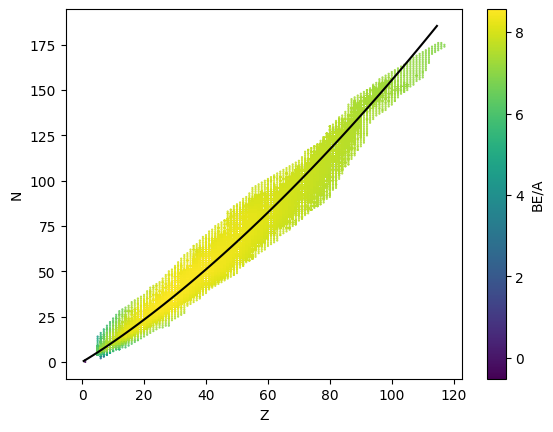

In [18]:
A = array(A,float64)
Z = array(Z,float64)
X = array([4*(A-(2*Z))]).T
y = array(aC*(2*Z-1)*(A**(2/3)))
aA, = LinearBatch(X,y).descend(random.randint(0,100,1),0.0000001)
print(aC,aA)
Plot(aC,aA)